Module 2:  Feature Engineering
======

Feature Engineering is the process of transforming raw data into features/input variables that are easily digested by algorithms. People think that data scientists often spend most of their time testing out various algorithms; however, the majority of performance gains generally come from well-crafted features. 

While performing feature engineering, it is critical to keep in mind the question that you are trying to answer.  For the purposes of this exercise, we will be using the KIVA dataset and will be trying to answering the following question:

__What drives the loan amount requested by KIVA borrowers?__

Our outcome feature is __loan_amount__. In the next notebook, we will formalize this research question as a machine learning task. Our machine learning task will be to predict the loan amount that a borrower requests from KIVA using all the features we explore in this notebook.

We may not end up using all the features we create, but the process is an important extension of exploratory analysis. The key difference between feature engineering and exploratory analysis is that we now have a defined question in mind: "What drives the loan amount requested by KIVA lenders?"

In this lab, we will introduce the following types of feature engineering:

1. Feature pruning
2. Time-based features (month, year, etc)
3. One-hot encoding to create dummy variables
4. Extracting features from strings
5. Metadata
6. Feature scaling
7. Data imputation / cleaning

In [3]:
import re

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn import preprocessing
import seaborn as sns

# Plotting defaults
plt.rcParams['figure.figsize'] = (15, 8)
sns.set()
sns.set(font_scale=1.5)

# Display up to 80 columns to keeps everything visible
pd.set_option('display.max_columns', 80)
pd.set_option('expand_frame_repr', True)

%matplotlib inline

In [4]:
# Load data
df = pd.read_csv("../data/raw_data.csv.zip", low_memory=False)
df.head()

,activity,basket_amount,bonus_credit_eligibility,borrowers,currency_exchange_loss_amount,description.languages,description.texts.en,description.texts.es,description.texts.fr,description.texts.ru,funded_amount,funded_date,id,image.id,image.template_id,journal_totals.bulkEntries,journal_totals.entries,lender_count,loan_amount,location.country,location.country_code,location.geo.level,location.geo.pairs,location.geo.type,location.town,name,partner_id,payments,planned_expiration_date,posted_date,sector,status,tags,terms.disbursal_amount,terms.disbursal_currency,terms.disbursal_date,terms.loan_amount,terms.local_payments,terms.loss_liability.currency_exchange,terms.loss_liability.currency_exchange_coverage_rate,...,themes,translator.byline,translator.image,use,video.id,video.thumbnailImageId,video.title,video.youtubeId,borrower_count,partner_average_loan_size_percent_per_capita_income,partner_charges_fees_and_interest,partner_countries,partner_currency_exchange_loss_rate,partner_default_rate,partner_default_rate_note,partner_delinquency_rate,partner_delinquency_rate_note,partner_image.id,partner_image.template_id,partner_loans_at_risk_rate,partner_loans_posted,partner_name,partner_portfolio_yield,partner_portfolio_yield_note,partner_profitability,partner_rating,partner_social_performance_strengths,partner_start_date,partner_status,partner_total_amount_raised,partner_url,posted_datetime,funded_datetime,planned_expiration_datetime,dispursal_datetime,number_of_loans,dispersal_date,posted_year,posted_month,time_to_fund
0,Farming,0.0,False,"[{'first_name': 'Evaline', 'last_name': '', 'g...",NaN,['en'],Evaline is a married lady aged 44 years old an...,NaN,NaN,NaN,0,NaN,1291548,2516002,1,0,0,0,500,Kenya,KE,town,-0.583333 35.183333,point,litein,Evaline,386.0,[],2017-06-08,2017-05-09,Agriculture,fundraising,"[{'name': '#Woman Owned Biz'}, {'name': '#Pare...",50000.0,KES,2017-04-03T07:00:00Z,500,"[{'due_date': '2017-05-10T07:00:00Z', 'amount'...",shared,0.1,...,NaN,Julie Keaton,892591.0,to purchase more tea leaves to sell to the tea...,NaN,NaN,NaN,NaN,1,0.0,True,"[{'iso_code': 'KE', 'region': 'Africa', 'name'...",0.120642,0.000000,NaN,7.017031,NaN,1592272.0,1.0,21.165398,1948.0,Kenya ECLOF,40.3,NaN,2.54,2.0,"[{'id': 3, 'name': 'Client Voice', 'descriptio...",2014-05-29T13:30:02Z,active,863375.0,http://www.eclof-kenya.org/,2017-05-09 00:40:03,NaN,2017-06-08 00:40:03,2017-04-03 07:00:00,1,2017-04-03,2017,5,NaN
1,Furniture Making,0.0,False,"[{'first_name': 'Julias', 'last_name': '', 'ge...",NaN,['en'],Aged 42 years is a man by the name of Julias. ...,NaN,NaN,NaN,0,NaN,1291532,2515992,1,0,0,0,500,Kenya,KE,town,0.566667 34.566667,point,Bungoma,Julias,386.0,[],2017-06-08,2017-05-09,Manufacturing,fundraising,[],50000.0,KES,2017-04-03T07:00:00Z,500,"[{'due_date': '2017-05-09T07:00:00Z', 'amount'...",shared,0.1,...,NaN,Morena Calvo,1832928.0,to buy timber to make more furniture for his e...,NaN,NaN,NaN,NaN,1,0.0,True,"[{'iso_code': 'KE', 'region': 'Africa', 'name'...",0.120642,0.000000,NaN,7.017031,NaN,1592272.0,1.0,21.165398,1948.0,Kenya ECLOF,40.3,NaN,2.54,2.0,"[{'id': 3, 'name': 'Client Voice', 'descriptio...",2014-05-29T13:30:02Z,active,863375.0,http://www.eclof-kenya.org/,2017-05-09 00:30:05,NaN,2017-06-08 00:30:05,2017-04-03 07:00:00,1,2017-04-03,2017,5,NaN
2,Home Energy,0.0,False,"[{'first_name': 'Rose', 'last_name': '', 'gend...",NaN,['en'],"Hello Kiva Community! <br /><br />Meet Rose, w...",NaN,NaN,NaN,50,NaN,1291530,2515991,1,0,0,2,75,Kenya,KE,town,0.516667 35.283333,point,Eldoret,Rose,156.0,[],2017-06-08,2017-05-09,Personal Use,fundraising,"[{'name': '#Eco-friendly'}, {'name': '#Technol...",6000.0,KES,2017-04-28T07:00:00Z,75,"[{'due_date': '2017-05-14T07:00:00Z', 'amount'...",shared,0.1,...,"['Green', 'Earth Day Campaign']",Julie Keaton,892591.0,to buy a solar lantern.,NaN,NaN,NaN,NaN,1,49.6,True,"[{'iso_code': 'KE', 'region': 'Africa', 'name'...",0.431935,2.575299,NaN,2.536684,NaN,1834079.0,1.0,24.200354,18150.0,Juhudi Kilimo,33.0,NaN,-7.1

## 1. Feature Pruning
No need to keep features that have zero variation.  Algorithms can only provide meaningful insights when there is variation in the features.  Given that we are performing feature engineering for the purpose of feeding these features into a machine learning algorithm, let's go ahead and remove all columns that only consist 1 or less unique values.

In [5]:
for col in df.columns:
    if df[col].unique().size==1:
        print("Dropping column: {0}".format(col))
        df = df.drop(col, axis=1)

Dropping column: image.template_id
Dropping column: journal_totals.bulkEntries
Dropping column: journal_totals.entries
Dropping column: location.country
Dropping column: location.country_code
Dropping column: location.geo.type
Dropping column: payments
Dropping column: partner_default_rate_note
Dropping column: partner_delinquency_rate_note
Dropping column: partner_image.template_id
Dropping column: partner_portfolio_yield_note
Dropping column: number_of_loans


## 2. Temporal Features
Time trends are very significant and should not be neglected.  Most algorithms will not be able to make use of raw datetimes; however, they will be able to find patterns in the data if they are informed which observations occur in a given year, on a weekday vs weekend, on a holiday, etc.

Before we are able to extract this metadata, let's convert the strings in the pandas dataframe to datetime objects. Luckily for us, all time fields in this dataset have "_date" in their name.

Pandas is really adept at time series analysis, and we will use pd.to_datetime to create pandas timestamps.
See a list of methods that can be applied to a pandas datetime here: https://pandas.pydata.org/pandas-docs/version/0.21/api.html#id34

In [6]:
for col in [c for c in df.columns if "_date" in c]:
    if "_date" in col:
        df[col] = pd.to_datetime(df[col])

### .dt accessor
The pandas .dt accessor enables you to easily construct additional features based off of these datetimes.

In [7]:
##  posted date features
df['posted_year']=df['posted_date'].dt.year
df['posted_month']=df['posted_date'].dt.month

## Time to fund is the funded date minus the posted date
## we add these fields because the homework question in the next notebook involves predicting time to fund
df['time_to_fund'] =df['funded_date'] - df['posted_date']
df['days_to_fund'] = df['time_to_fund'].dt.days

# expiration date features
## Time to expiration is the expiration date minus the Posted Date
df['time_to_expire_date'] =df['planned_expiration_date'] - df['posted_date']
df['days_to_expire'] = df['time_to_expire_date'].dt.days

## 3. One-hot encoding
One-hot encoding is the process of converting either categorical or string data into a binary. Let's practice one-hot encoding by converting the "tags" column into a set of binary features indicating whether or not a particular tag appears in a given row. 

In order to do this we will first need to convert the "tags" column into a list of strings. Then, we will utilize the pandas `get_dummies` method to create the binary features.  Binary features are often referred as dummy features in the statistics world.



In [8]:
df['tag_list'] = df['tags'].apply(lambda x: [elem['name'] for elem in eval(x)])
tag_df = pd.get_dummies(df['tag_list'].apply(pd.Series).stack()).sum(level=0)
# TODO - Explain how merges work or better yet figure a way to avoid merging. - Jack 11/10/17
df = df.merge(tag_df, left_index = True, right_index = True, how = 'outer')

In [9]:
df[tag_df.columns] = df[tag_df.columns].fillna(0)

In [10]:
df.columns

Index(['activity', 'basket_amount', 'bonus_credit_eligibility', 'borrowers',
       'currency_exchange_loss_amount', 'description.languages',
       'description.texts.en', 'description.texts.es', 'description.texts.fr',
       'description.texts.ru',
       ...
       '#Technology', '#Tourism', '#Trees', '#Unique', '#Vegan', '#Widowed',
       '#Woman Owned Biz', 'user_favorite', 'volunteer_like',
       'volunteer_pick'],
      dtype='object', length=112)

4. Extracting features from strings
------

String variables by themselves are generally not good inputs to algorithms; however, it is often possible to extract meaningful features from encoding the information that they contain.  Let's first find out which of our variables are string variables.  From there, let's review some of the variables and see if we can construct new features from the contents of these string variables.

To discover which of our dataframe columns are string variables, we will utilize the pandas `dtypes` method, short for 'data type'.  In pandas, there are the following types:

|       dtype        |        Description        |
|--------------------|---------------------------|
|      float         | Numeric value with a decimal point.  If NaNs exist in col, pandas will default to float|
|        int         | Numerica values without decimal points. |
|       bool         | Column consisting of True and False|
| datetime64[ns, tz] | Objects which contain specific date and time |
|   timedelta[ns]    | Object which indicates time elapsed between two datetimes |
|     category       | Variables that can only have specified values |
|      object        | Pandas representation of string variables |

Let's now use pandas method `get_dtype_counts` to see what data types exist in the dataframe, and then apply `select_dtypes` to view all columns with `dtype == object`.

In [11]:
df.get_dtype_counts()

bool                2
datetime64[ns]     10
float64            56
int64              10
object             32
timedelta64[ns]     2
dtype: int64

In [12]:
df.select_dtypes(include=[object])

,activity,borrowers,description.languages,description.texts.en,description.texts.es,description.texts.fr,description.texts.ru,location.geo.level,location.geo.pairs,location.town,name,sector,status,tags,terms.disbursal_currency,terms.local_payments,terms.loss_liability.currency_exchange,terms.loss_liability.nonpayment,terms.repayment_interval,terms.scheduled_payments,themes,translator.byline,use,video.title,video.youtubeId,partner_countries,partner_name,partner_rating,partner_social_performance_strengths,partner_status,partner_url,tag_list
0,Farming,"[{'first_name': 'Evaline', 'last_name': '', 'g...",['en'],Evaline is a married lady aged 44 years old an...,NaN,NaN,NaN,town,-0.583333 35.183333,litein,Evaline,Agriculture,fundraising,"[{'name': '#Woman Owned Biz'}, {'name': '#Pare...",KES,"[{'due_date': '2017-05-10T07:00:00Z', 'amount'...",shared,lender,Monthly,"[{'due_date': '2017-07-01T07:00:00Z', 'amount'...",NaN,Julie Keaton,to purchase more tea leaves to sell to the tea...,NaN,NaN,"[{'iso_code': 'KE', 'region': 'Africa', 'name'...",Kenya ECLOF,2.0,"[{'id': 3, 'name': 'Client Voice', 'descriptio...",active,http://www.eclof-kenya.org/,"[#Woman Owned Biz, #Parent]"
1,Furniture Making,"[{'first_name': 'Julias', 'last_name': '', 'ge...",['en'],Aged 42 years is a man by the name of Julias. ...,NaN,NaN,NaN,town,0.566667 34.566667,Bungoma,Julias,Manufacturing,fundraising,[],KES,"[{'due_date': '2017-05-09T07:00:00Z', 'amount'...",shared,lender,Monthly,"[{'due_date': '2017-07-01T07:00:00Z', 'amount'...",NaN,Morena Calvo,to buy timber to make more furniture for his e...,NaN,NaN,"[{'iso_code': 'KE', 'region': 'Africa', 'name'...",Kenya ECLOF,2.0,"[{'id': 3, 'name': 'Client Voice', 'descriptio...",active,http://www.eclof-kenya.org/,[]
2,Home Energy,"[{'first_name': 'Rose', 'last_name': '', 'gend...",['en'],"Hello Kiva Community! <br /><br />Meet Rose, w...",NaN,NaN,NaN,town,0.516667 35.283333,Eldoret,Rose,Personal Use,fundraising,"[{'name': '#Eco-friendly'}, {'name': '#Technol...",KES,"[{'due_date': '2017-05-14T07:00:00Z', 'amount'...",shared,lender,Monthly,"[{'due_date': '2017-07-01T07:00:00Z', 'amount'...","['Green', 'Earth Day Campaign']",Julie Keaton,to buy a solar lantern.,NaN,NaN,"[{'iso_code': 'KE', 'region': 'Africa', 'name'...",Juhudi Kilimo,2.0,"[{'id': 1, 'name': 'Anti-Poverty Focus', 'desc...",active,http://www.juhudikilimo.com/,"[#Eco-friendly, #Technology]"
3,Used Clothing,"[{'first_name': 'Jane', 'last_name': '', 'gend...",['en'],"Jane was born in the 1980, and she is happily ...",NaN,NaN,NaN,town,0.566667 34.566667,Bungoma,Jane,Clothing,fundraising,[{'name': '#Eco-friendly'}],KES,"[{'due_date': '2017-05-08T07:00:00Z', 'amount'...",shared,lender,Monthly,"[{'due_date': '2017-07-01T07:00:00Z', 'amount'...",NaN,Julie Keaton,to buy more clothes to meet the needs and tast...,NaN,NaN,"[{'iso_code': 'KE', 'region': 'Africa', 'name'...",Kenya ECLOF,2.0,"[{'id': 3, 'name': 'Client Voice', 'descriptio...",active,http://www.eclof-kenya.org/,[#Eco-friendly]
4,Farming,"[{'first_name': 'Alice', 'last_name': '', 'gen...",['en'],Alice (the woman pictured above in her small s...,NaN,NaN,NaN,town,1 38,Nandi Hills,Alice,Agriculture,fundraising,[{'name': '#Woman Owned Biz'}],KES,"[{'due_date': '2017-05-27T07:00:00Z', 'amount'...",shared,lender,Monthly,"[{'due_date': '2017-07-01T07:00:00Z', 'amount'...",['Rural Exclusion'],NaN,"to buy farming inputs (fertilizers, pesticides...",NaN,NaN,"[{'iso_code': 'KE', 'region': 'Africa', 'name'...",Juhudi Kilimo,2.0,"[{'id': 1, 'name': 'Anti-Poverty Focus', 'desc...",active,http://www.juhudikilimo.com/,[#Woman Owned Biz]
5,Used Clothing,"[{'first_name': 'Clare', 'last_name': '', 'gen...",['en'],Clare is a married woman who is blessed with 2...,NaN,NaN,NaN,town,0.416667 34.25,Busia,Clare,Clothing,fundraising,"[{'name': '#Woman Owned Biz'}, {'name': '#Eco-...",KES,"[{'due_date': '2017-05-11T07:00:00Z', 'amount'...",shared,lender,Monthly,"[{'due_date': '2017-07-01T07:00:00Z', 'amount'...",NaN,NaN,to buy more 

The borrowers column looks like it may have some interesting information, but it is hard to tell since the string is cropped in the displayed dataframe.  Let's take a look at an example value.

In [13]:
df['borrowers'][0]

"[{'first_name': 'Evaline', 'last_name': '', 'gender': 'F', 'pictured': True}]"

A very simple feature we can create is a count for the number of borrowers listed.  In order to accomplish this, we will leverage the pandas [apply](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.apply.html) method, which allows us to apply a lambda function to a specific column or collection of columns in order to create a new vector.  The provided lambda function is applied to each row in order to calculate the value of the corresponding row in the new vector.

In [42]:
df['num_borrowers'] = df['borrowers'].apply(lambda x: x.count("{"))
df['num_tags'] = df['tags'].apply(lambda x: x.count(','))
print(df[df['num_borrowers']>1]['num_borrowers'].iloc[0])

4


In [57]:
eval(df[df['num_borrowers']>1]['borrowers'].iloc[0]) # eval remove the string data

[{'first_name': 'Florence ', 'last_name': '', 'gender': 'F', 'pictured': True},
 {'first_name': 'Wanjiru', 'last_name': '', 'gender': 'F', 'pictured': True},
 {'first_name': 'Jane ', 'last_name': '', 'gender': 'F', 'pictured': True},
 {'first_name': 'Pauline ', 'last_name': '', 'gender': 'F', 'pictured': True}]

Keeping in mind that the question that we are trying to answer is "What drives the loan amount requested by KIVA borrowers?", let's create a few variables that encode the information on the gender of the listed borrowers.

In order to do this, we will once again use the pandas `apply` method, but this time, we will introduce an if-else statement inside the lambda function.  This will enable us to change the value of the resulting column vector based on whether the conditional returns `True` or `False` for each row.

In [15]:
df['female']=df['borrowers'].apply(lambda x: 0 if x.split("gender': '")[1][0]=='M' else 1)
df['num_male'] = df['borrowers'].apply(lambda x: x.count('''M'''))
df['num_female'] = df['borrowers'].apply(lambda x: x.count('''F'''))
df['pct_female']=100.00*df['num_female']/(df['num_male']+df['num_female'])

Next up: marital status and a boolean for whether or not they have kids.  These features will all be booleans. In order to construct, them we will use the pandas [str.contains](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.Series.str.contains.html).  This is a handy feature because it allows us to utilize a [regex](https://docs.python.org/2/library/re.html).

In [16]:
## Whether or not the borrower is widowed
##  Note the str.contains function
df['widowed'] = df['description.texts.en'].str.contains("widowed|widow", na=False) * 1.0
## Whether or not the borrower is married
df['married'] = np.where(df['description.texts.en'].str.contains("married|husband|wife", na=False)==True, 1, 0) * 1.0
## Whether or not the borrower has children, notice we look for many variants of the word.
df['kids'] = df['description.texts.en'].str.contains("kids|child|children|kid|son|daughter|mother|father|parents", na=False) * 1.0
df['parent'] = np.where(df['#Parent']==1, df['#Parent'], df['kids'])

### Age and number of children

Creating variables for age will be a bit tricky. In the cells below, we parse out the age of the user by doing the following:

1. Importing a CSV mapping of age strings that appear in the Kiva description field (e.g. "2 years") to the integer counterparts (e.g. 2).
2. We then define a function to check for each of these string values within the description.texts.en field of our main dataframe. If a match is found, we append that string value to a new list, "age", which we create at the start of the function. If no match is found, we append a blank string. When the function has completed, we have a list the same length of our main dataframe, with the corresponding age string value for each observation (e.g. "2 years" or " " if there is no age value available).
    1. We use functions from the regular expression package to perform the string searches within the description.texts.en. Specifically, we use re.compile and  re.findall functions to first compile all possible age strings of interest, and then find all instances of the corresponding string.
3. We then create a new column in our main dataframe, "age", which is simply the list we created in step 2.
4. Finally, we perform a left join of our main dataframe with the CSV mapping, to map the string versions of age with their integer counterparts.

In [17]:
lookup_tags = pd.read_csv('../data/tags.csv')
lookup_tags.head(2)

,age,age_int,children_1,children_2,children_int
0,1 years,1,one child,1 child,1.0
1,2 years,2,two children,2 children,2.0


In [58]:
## Age of borrower and number of children
#  define a function that performs a loop that parses out all words, 
#  finds age and number of children match and creates a list that is return at the end of the function
def text_search(tag):
    "Creates empty lists that are then added to in loop"
    number=[]
    flag = tag.astype(str)
    match = flag.tolist()
    match = re.compile(r'\b(?:%s)\b' % '|'.join(match))
    for descr in df['description.texts.en']:
        try:
            if isinstance(descr, str):
                    if re.findall(match, descr):
                        match_0=re.findall(match,  descr)
                        match_1=re.findall(match,  descr)[:1]
                        word_1=" ".join(match_1)
                        number.append(word_1)
                    else:
                        number.append('')
        except:
            print('error')
            
    return(number)

In the cell below, we write a small loop to go through each feature and search. Running this loop is fairly computationally expensive, since it is doing a string match against every row of the data. You can expect it to take a few minutes to run. You can add other lists to the tags csv to extend the features you search for.

In [19]:
features=['age','children_1', 'children_2'] 
for feature in features:
    number= text_search(lookup_tags[feature])
    df[feature]=pd.DataFrame(number)

In [60]:
df.head(2)
print(f"{len(df.index):,}")

118,199


Finally, we map the integer fields onto our dataframe. That way, we can decide whether to use number of children as a `str` feature or an `int` feature.

In [21]:
mydict = dict(zip(lookup_tags.children_1, lookup_tags.children_int))
df['children_int_1'] = df['children_1'].map(mydict)

mydict = dict(zip(lookup_tags.children_2, lookup_tags.children_int))
df['children_int_2'] = df['children_2'].map(mydict)

mydict = dict(zip(lookup_tags.age, lookup_tags.age_int))
df['age_int'] = df['age'].map(mydict)

In [22]:
df['children_int'] = df['children_int_1'].fillna(df['children_int_2'])
df['children_int'] = df['children_int'].fillna(0)

## 5. Metadata

We have data specifying which partners provided the loan for each row; however, this information alone is not that helpful.  Let's try to extract some metadata from the dataset to learn how impactful partners are.

In [23]:
print("Number of unique partners: {0} \n".format(len(df['partner_name'].unique())))
print("Top 15 partners: \n{0}\n".format(df['partner_name'].value_counts().head(15)))
print("Bottom 5 partners: \n{0}".format(df['partner_name'].value_counts().tail(15)))

Number of unique partners: 40 

Top 15 partners: 
VisionFund Kenya                               28570
Yehu Microfinance Trust                        21570
SMEP Microfinance Bank                         18111
Juhudi Kilimo                                  18079
One Acre Fund                                  10348
Faulu Kenya                                     5922
Hand in Hand Eastern Africa                     3212
Milango Financial Services                      2991
Kenya ECLOF                                     2388
Women`s Economic Empowerment Consort (WEEC)     1102
Honey Care Africa                                916
K-Met Savings and Credit Cooperative Ltd         901
Ebony Foundation (Eb-F)                          833
Evidence Action                                  519
Sanergy                                          377
Name: partner_name, dtype: int64

Bottom 5 partners: 
Takamoto Biogas                          79
Junior Achievement Kenya                 78
Motorbank Ken

There is a huge disparity between the number of loans provided per partner.  This information could be informative.

In [24]:
# let's only include those that have > 1000 obs (top 10)
top_partners = df['partner_name'].value_counts().index[:10]
top_partner_ids = df['partner_id'].value_counts().index[:10]
df['top_partners'] = df['partner_name'].apply(lambda x: x if x in top_partners else "Other")
df['top_partner_id'] = df['partner_id'].apply(lambda x: x if x in top_partner_ids else -1)

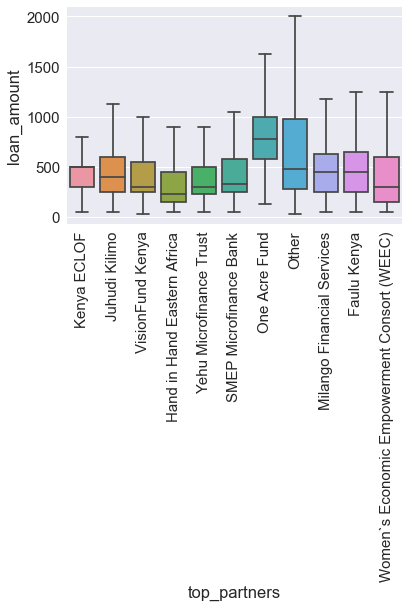

In [61]:
ax = sns.boxplot(x=df['top_partners'], y=df['loan_amount'],showfliers=False)
ax.set_xticklabels(labels=ax.get_xticklabels(), rotation = 90);

We know from Kiva that an exploratory partner who does not have a proven track record can be tested using a seed sum of $50,000. Let's create a boolean feature for exploratory partner in case we want to remove or otherwise treat these partners differently.

In [26]:
partner_dollar_amount = pd.DataFrame(df[(df['borrower_count'] == 1)].groupby(['partner_name','posted_year']).sum()['loan_amount'])
partner_dollar_amount.columns = ['partner_dollar_amount']
df = df.merge(partner_dollar_amount, left_on=['partner_name','posted_year'], right_index=True, how='outer')

In [27]:
df['exploratory_partner']=np.where(df['partner_dollar_amount']>50000,0,1)

In [28]:
df[(df['borrower_count'] == 1)]['exploratory_partner'].value_counts()

0    103765
1      1442
Name: exploratory_partner, dtype: int64

## 6. Feature Scaling

We will not overwrite our dataframe with scaled values because the appropriate scaling technique depends on the algorithm.  These are the three most common feature scaling techniques:
1. Normalization
2. Standardization
3. Log-transformation

Normalization is the process of rescaling the data from 0-1.  The formula for this approach is:

`X_std = (X - X.min(axis=0)) / (X.max(axis=0) - X.min(axis=0))
X_scaled = X_std * (max - min) + min` 

In [29]:
preprocessing.MinMaxScaler()
min_max_scaler = preprocessing.MinMaxScaler()
normalized = min_max_scaler.fit_transform(df['loan_amount'].astype(np.float64).values.reshape(-1,1))[:,0]
print("Pre Scaling\tMin: {0}\t\t Max: {1}\tMean: {2}".format(df['loan_amount'].min(),df['loan_amount'].max(),df['loan_amount'].mean()))
print("Post Scaling\tMin: {0}\t Max: {1}\tMean: {2}".format(np.min(normalized),np.max(normalized),np.mean(normalized)))

Pre Scaling	Min: 25		 Max: 6000	Mean: 481.2718381712197
Post Scaling	Min: 0.0	 Max: 1.0000000000000002	Mean: 0.07636348756003679


Standardization assumes normally distributed data (i.e., Gaussian) and scales the data so that it has a zero mean and unit variance.  Below is the formula:
$${\dfrac{x - \bar x}{\sigma}}$$

In [30]:
standardized = preprocessing.scale(df['loan_amount'].astype(np.float64))
print("Post Scaling\tMin: {0}\t Max: {1}\tMean: {2}".format(np.min(standardized),np.max(standardized),np.mean(standardized)))

Post Scaling	Min: -1.0935009006414065	 Max: 13.226181654214393	Mean: 1.9236514305809023e-18


From these values, it appears that our data has a skewed distribution and is actually a good candidate for a log transformation.

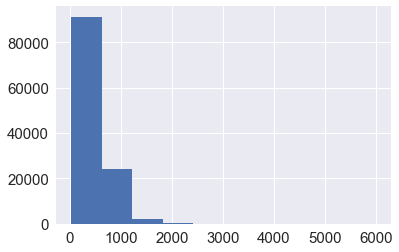

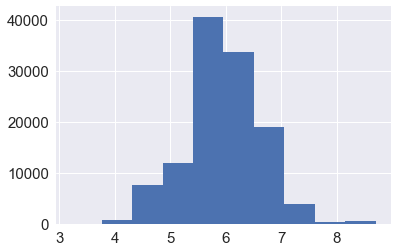

In [31]:
plt.hist(df['loan_amount'])
plt.show()
log_loan_amount = np.log(df['loan_amount'])
plt.hist(log_loan_amount)
plt.show()

## 7. Data Imputation / cleaning

Missing data can be informative, but it also will prevent many algorithms from training.  In order to enable our models to train while preserving the fact that some data is missing, we are going to:
1. Create a new column that indicates whether or not that column had missing data.
In pandas, missing data is either represented as NaN (Not a Number), or NaT (Not a Time).  While we look at our missing data, let's look at strings, numeric, and time objects separately.

2. Impute missing data with the column's mean.

First, let's have a quick refresher on data types in our dataframe and create lists of all of the columns for specific data types.

In [32]:
df.get_dtype_counts()

bool                2
datetime64[ns]     10
float64            67
int64              16
object             36
timedelta64[ns]     2
dtype: int64

In [33]:
time_columns = df.select_dtypes(include=['datetime64','timedelta64']).columns
str_columns = df.select_dtypes(include=[object]).columns
numeric_columns = df.select_dtypes(exclude=[object,'datetime64','timedelta64']).columns

Now, let's use pandas `isnull` and `sum` functions to see how many observations of each column are missing.
Since there are a lot of columns in this dataframe, let's restrict our returned dataframe to columns which have 
missing data

In [34]:
df[time_columns].isnull().sum()[df[time_columns].isnull().sum()>0]

funded_date                     5605
planned_expiration_date        24913
funded_datetime                 5605
planned_expiration_datetime    24913
time_to_fund                    5605
time_to_expire_date            24913
dtype: int64

In [35]:
df[str_columns].isnull().sum()[df[str_columns].isnull().sum()>0]

description.texts.en                      4326
description.texts.es                    118196
description.texts.fr                    118196
description.texts.ru                    118195
location.town                             7894
terms.repayment_interval                117257
themes                                   89300
translator.byline                        35887
use                                       4325
video.title                             118133
video.youtubeId                         118133
partner_social_performance_strengths      4531
partner_url                               4059
age                                       4326
children_1                                4326
children_2                                4326
dtype: int64

In [36]:
df[numeric_columns].isnull().sum()[df[numeric_columns].isnull().sum()>0]

basket_amount                                           117257
currency_exchange_loss_amount                           102524
terms.loss_liability.currency_exchange_coverage_rate      3849
translator.image                                         55223
video.id                                                118133
video.thumbnailImageId                                  118133
partner_portfolio_yield                                   6305
partner_profitability                                    11388
days_to_fund                                              5605
days_to_expire                                           24913
children_int_1                                           68784
children_int_2                                          104316
age_int                                                  62562
partner_dollar_amount                                    10188
dtype: int64

With missing data, you should always check to see if there is a systemic difference between observations with and without missing data.

In [37]:
df[df['funded_date'].isnull()].describe()

,basket_amount,currency_exchange_loss_amount,funded_amount,id,image.id,lender_count,loan_amount,partner_id,terms.disbursal_amount,terms.loan_amount,terms.loss_liability.currency_exchange_coverage_rate,terms.repayment_term,translator.image,video.id,video.thumbnailImageId,borrower_count,partner_average_loan_size_percent_per_capita_income,partner_currency_exchange_loss_rate,partner_default_rate,partner_delinquency_rate,partner_image.id,partner_loans_at_risk_rate,partner_loans_posted,partner_portfolio_yield,partner_profitability,partner_total_amount_raised,posted_year,posted_month,time_to_fund,days_to_fund,time_to_expire_date,days_to_expire,#Animals,#Biz Durable Asset,#Eco-friendly,#Elderly,#Fabrics,#Female Education,#First Loan,#Health and Sanitation,...,#Married,#Orphan,#Parent,#Post-disbursed,#Refugee,#Repair Renew Replace,#Repeat Borrower,#Schooling,#Single,#Single Parent,#Supporting Family,#Sustainable Ag,#Team Guys Holding Fish,#Technology,#Tourism,#Trees,#Unique,#Vegan,#Widowed,#Woman Owned Biz,user_favorite,volunteer_like,volunteer_pick,num_borrowers,num_tags,female,num_male,num_female,pct_female,widowed,married,kids,parent,children_int_1,children_int_2,age_int,children_int,top_partner_id,partner_dollar_amount,exploratory_partner
count,942.000000,0.0,5605.000000,5.605000e+03,5.605000e+03,5605.000000,5605.000000,5605.000000,5605.000000,5605.000000,5605.000000,5605.000000,2.922000e+03,0.0,0.0,5605.000000,5605.000000,5605.000000,5605.000000,5605.000000,5.605000e+03,5605.000000,5605.000000,5579.000000,5479.000000,5.605000e+03,5605.000000,5605.000000,0,0.0,5605,5605.000000,5605.000000,5605.000000,5605.000000,5605.000000,5605.000000,5605.000000,5605.000000,5605.000000,...,5605.0,5605.000000,5605.000000,5605.000000,5605.000000,5605.000000,5605.000000,5605.000000,5605.000000,5605.000000,5605.000000,5605.000000,5605.0,5605.000000,5605.0,5605.000000,5605.000000,5605.000000,5605.000000,5605.000000,5605.000000,5605.000000,5605.000000,5605.000000,5605.000000,5605.000000,5605.000000,5605.000000,5605.000000,5605.000000,5605.000000,5605.000000,5605.000000,2165.000000,1178.000000,3026.000000,5605.000000,5605.000000,4.410000e+03,5605.000000
mean,0.185775,NaN,377.359500,1.008602e+06,2.055291e+06,9.881178,825.267618,184.322391,78329.117172,825.267618,0.100749,13.603211,1.253517e+06,NaN,NaN,3.523996,26.225638,0.253395,1.848365,4.902161,1.338721e+06,13.081839,15758.540589,25.541638,6.701650,7.239015e+06,2015.473149,6.153970,NaT,NaN,30 days 19:35:22.747546,30.816236,0.080464,0.104728,0.232293,0.125245,0.010348,0.000178,0.071186,0.001606,...,0.0,0.000178,0.674041,0.027297,0.000178,0.018198,0.398751,0.217306,0.022837,0.006780,0.038894,0.215522,0.0,0.194469,0.0,0.014451,0.003747,0.245495,0.002319,0.285816,0.225870,0.016949,0.024621,3.523996,2.380196,0.403033,2.201606,1.853880,42.716996,0.002676,0.638359,0.890277,0.901160,3.958891,4.734295,29.031064,2.520071,182.641392,1.308985e+06,0.255308
std,2.148199,NaN,412.518935,2.356164e+05,3.823396e+05,9.666373,660.029699,74.130497,57275.877845,660.029699,0.008625,4.544167,6.441898e+05,NaN,NaN,4.572597,20.316244,0.129572,1.904977,4.692375,5.987030e+05,9.899934,8390.039856,14.557297,13.912514,2.824904e+06,1.368244,3.200534,NaT,NaN,4 days 02:07:17.347022,4.088395,0.272034,0.306230,0.422332,0.331026,0.101206,0.013357,0.257159,0.040043,...,0.0,0.013357,0.468774,0.162962,0.013357,0.133679,0.489685,0.412449,0.149396,0.082066,0.193359,0.411221,0.0,0.395827,0.0,0.119353,0.061101,0.430419,0.048108,0.451843,0.418191,0.129092,0.154981,4.572597,2.001909,0.490551,3.056924,2.804138,41.672218,0.051667,0.480519,0.312573,0.298474,2.052380,2.661573,17.928315,2.737863,73.943251,7.336069e+05,0.436073
min,0.000000,NaN,0.000000,3.894270e+05,5.990510e+05,0.000000,75.000000,133.000000,3600.000000,75.000000,0.100000,8.000000,2.873300e+04,NaN,NaN,1.000000,0.000000,0.000000,0.000000,0.000000,3.281970e+05,0.000000,73.000000,1.000000,-7.100000,3.552500e+04,2012.000000,1.000000,NaN,NaN,30 days 00:00:00,30.000000,0.000000,0.000000,0.00000

In [38]:
df[~df['funded_date'].isnull()].describe()

,basket_amount,currency_exchange_loss_amount,funded_amount,id,image.id,lender_count,loan_amount,partner_id,terms.disbursal_amount,terms.loan_amount,terms.loss_liability.currency_exchange_coverage_rate,terms.repayment_term,translator.image,video.id,video.thumbnailImageId,borrower_count,partner_average_loan_size_percent_per_capita_income,partner_currency_exchange_loss_rate,partner_default_rate,partner_delinquency_rate,partner_image.id,partner_loans_at_risk_rate,partner_loans_posted,partner_portfolio_yield,partner_profitability,partner_total_amount_raised,posted_year,posted_month,time_to_fund,days_to_fund,time_to_expire_date,days_to_expire,#Animals,#Biz Durable Asset,#Eco-friendly,#Elderly,#Fabrics,#Female Education,#First Loan,#Health and Sanitation,...,#Married,#Orphan,#Parent,#Post-disbursed,#Refugee,#Repair Renew Replace,#Repeat Borrower,#Schooling,#Single,#Single Parent,#Supporting Family,#Sustainable Ag,#Team Guys Holding Fish,#Technology,#Tourism,#Trees,#Unique,#Vegan,#Widowed,#Woman Owned Biz,user_favorite,volunteer_like,volunteer_pick,num_borrowers,num_tags,female,num_male,num_female,pct_female,widowed,married,kids,parent,children_int_1,children_int_2,age_int,children_int,top_partner_id,partner_dollar_amount,exploratory_partner
count,0.0,15675.000000,112594.000000,1.125940e+05,1.125940e+05,112594.000000,112594.000000,112594.000000,112594.000000,112594.000000,108745.000000,112594.000000,6.005400e+04,66.000000,6.600000e+01,112594.000000,112594.000000,112594.000000,112594.000000,112594.000000,1.125940e+05,112594.000000,112594.000000,106315.000000,101332.000000,1.125940e+05,112594.000000,112594.000000,112594,112594.000000,87681,87681.000000,112594.000000,112594.000000,112594.000000,112594.000000,112594.000000,112594.000000,112594.000000,112594.000000,...,112594.000000,112594.000000,112594.000000,112594.000000,112594.00000,112594.000000,112594.000000,112594.000000,112594.000000,112594.000000,112594.000000,112594.000000,112594.000000,112594.000000,112594.000000,112594.000000,112594.000000,112594.000000,112594.000000,112594.000000,112594.000000,112594.000000,112594.000000,112594.000000,112594.000000,112594.000000,112594.000000,112594.000000,112594.000000,112594.000000,112594.000000,112594.000000,112594.000000,47250.000000,12705.000000,52611.000000,112594.000000,112594.000000,1.036010e+05,112594.000000
mean,NaN,6.792162,464.147290,6.947033e+05,1.515251e+06,14.438407,464.147512,163.978525,39251.496748,464.147512,0.123275,13.394488,1.161408e+06,1038.878788,4.639814e+05,1.849921,30.243646,0.210464,3.921710,4.318690,1.504613e+06,11.439857,18311.720101,31.347426,2.129251,7.319433e+06,2013.463204,6.438380,8 days 00:08:54.849103,8.006190,31 days 07:22:34.295685,31.307341,0.057525,0.041459,0.074480,0.042400,0.014912,0.001021,0.046042,0.007531,...,0.000062,0.000355,0.273523,0.011004,0.00008,0.002789,0.097705,0.090298,0.007061,0.012274,0.013766,0.056211,0.000107,0.056104,0.000133,0.006430,0.001901,0.083983,0.005942,0.183376,0.125611,0.016386,0.024335,1.849850,0.949251,0.678686,0.895341,1.265574,61.591585,0.022763,0.640292,0.854504,0.861174,3.762561,4.478788,29.590580,2.082482,154.007762,1.229073e+06,0.103904
std,NaN,9.857512,393.581035,3.389774e+05,6.020923e+05,12.746949,393.581048,65.326218,33307.752331,393.581048,0.042258,7.911643,7.061734e+05,851.989988,2.600692e+05,2.908130,16.883660,0.267244,10.721899,5.396262,6.013932e+05,10.863203,9445.391231,10.095670,11.090370,3.305884e+06,2.341688,3.576108,12 days 08:58:11.053166,12.373739,5 days 14:51:54.832081,5.619385,0.232845,0.199349,0.262552,0.201501,0.121201,0.031943,0.209576,0.086457,...,0.007885,0.018845,0.445769,0.104322,0.00894,0.052735,0.296917,0.286609,0.083732,0.110107,0.116520,0.230329,0.010323,0.230124,0.011541,0.079931,0.043555,0.277364,0.076853,0.386976,0.331411,0.126956,0.154088,2.908136,1.587573,0.466983,1.673018,2.052556,43.203548,0.149148,0.479917,0.352602,0.345767,1.979156,2.433572,16.981896,2.483073,65.736079,7.042762e+05,0.305138
min,NaN,0.010000,25.000000,2.510000e+02,4

Create columns that indicate whether or not data is missing:

In [39]:
for col in numeric_columns:
    df[col+'_na'] = pd.isnull(df[col])

Impute missing data with the mean:

In [40]:
df[numeric_columns] = df[numeric_columns].fillna(df[numeric_columns].mean())

THE END!
-----

That is all for our feature engineering module!  

Now that we have finished creating all of our features, we can go ahead and explore them with some EDA!  

The optimal last step of this module is to save our results into a new csv.

In [41]:
# df.to_csv("../data/clean_data.csv", index=False) # This command is commented out because the data has already been saved in our data repository)

<br>
<br> 
<br>

----